# Calculating an observable of an interacting impurity in a fermionic bath
## Preparations
First make sure that you have installed the latest versions of imcode, freeferm and ttarray.

```
git clone https://github.com/sonnerm/imcode
pip install --editable ./imcode/
git clone https://github.com/sonnerm/freeferm
pip install --editable ./freeferm/
git clone https://github.com/sonnerm/ttarray
pip install --editable ./ttarray/
```
It is recommended to use a virtual environment since those libraries are under active development. You'll also need numpy, scipy, h5py and matplotlib. 


In [1]:
import imcode
import ttarray
import freeferm
import numpy as np
import scipy.linalg as sla
import h5py
import matplotlib.pyplot as plt

## Load correlations from hdf5 File
(Maybe Julian can insert some code to generate the correlations from scratch)

In [2]:
with h5py.File("/Users/julianthoenniss/Documents/PhD/data/compmode=C_o=1_Jx=1.0_Jy=1.0_g=0.0mu=0.0_del_t=0.1_beta=0.0_L=10_init=3_coupling=1.0_Michael_convention_correlations.hdf5","r") as f:
    correlations_j=np.array(f["corr_t=3"])
t=correlations_j.shape[0]//8

## Convert to Majorana correlation matrix
Julian's correlation matrix come in a block form $$\Lambda_j = \left(\begin{array}{c c}\langle c^\dagger c\rangle&\langle c c \rangle \\ \langle c^\dagger c^\dagger \rangle & \langle c c^\dagger \rangle \end{array}\right),$$ but we need it in terms of Majorana operators.
$$\Lambda_m = \langle \gamma \gamma \rangle$$

In [3]:
def convert_conventions(jcorr):
    L=jcorr.shape[0]//2
    jcorrn=np.zeros_like(jcorr)
    jcorrn[::2,::2]=jcorr[:jcorr.shape[0]//2,:jcorr.shape[1]//2]
    jcorrn[1::2,::2]=jcorr[jcorr.shape[0]//2:,:jcorr.shape[1]//2]
    jcorrn[1::2,1::2]=jcorr[jcorr.shape[0]//2:,jcorr.shape[1]//2:]
    jcorrn[::2,1::2]=jcorr[:jcorr.shape[0]//2,jcorr.shape[1]//2:]
    roti=np.diag([1,0]*L,1)[:-1,:-1]+np.diag([1j,0]*L,-1)[:-1,:-1]+np.diag([1,-1j]*L)
    jcorrf=(roti@jcorrn@roti.T.conj())
    jcorrf=(jcorrf-np.diag(np.diag(jcorrf)))/2
    jcorrf[2::4,:]=-jcorrf[2::4,:]
    jcorrf[3::4,:]=-jcorrf[3::4,:]
    jcorrf[:,2::4]=-jcorrf[:,2::4]
    jcorrf[:,3::4]=-jcorrf[:,3::4]
    return jcorrf
correlations_m=convert_conventions(correlations_j)

## Convert Majorana correlation matrix to circuit
This routine uses the Majorana Fishman-White algorithm to obtain the circuit which rotates the vacuum to the Gaussian state described by our correlation matrix. For the purpose of this demonstration, choosing a cutoff of $10^{-8}$ is definitely sufficient.

In [4]:
circuit=freeferm.real.corr_to_circuit(correlations_m,nbcutoff=1e-10)

## Convert circuit to MPS
To obtain the Influence Matrix MPS we apply the circuit to the vacuum MPS. For faster computations, we choose a maximal bond dimension $\chi=128$ and a (relative) svd-cutoff of $10^{-12}$. The `cluster` argument of mps_vac determines to which tensor the physical legs are attached in the MPS,


In [129]:
mps_im025=freeferm.apply_circuit_to_mps(freeferm.mps_vac(4*t,cluster=((16,),)*t),circuit,chi=128,cutoff=1e-12)

In [101]:
mps_im05=freeferm.apply_circuit_to_mps(freeferm.mps_vac(4*t,cluster=((16,),)*t),circuit,chi=128,cutoff=1e-12)

In [5]:
mps_im01=freeferm.apply_circuit_to_mps(freeferm.mps_vac(4*t,cluster=((16,),)*t),circuit,chi=128,cutoff=1e-12)
print(mps_im01)

TensorTrainArray<dtype=complex128, shape=(4096,), L=3, cluster=((16,), (16,), (16,)), chi=(4, 4)>


## Define impurity initial state and channel

For this demonstration we want to compare later to exact results. Hence our local unitary evolution needs to correspond to a non-interacting free fermion model. Here we choose a spin flip term $J=3$ and a local on-site potential $E=4$, both scaled with the timestep $\mathrm{d}t=0.1$:
$$\hat{U} = e^{i\mathrm{d}t J (S^x \otimes S^x + S^y \otimes S^y) + i \mathrm{d}t E (S^z\otimes 1 + 1 \otimes S^z)}$$
To break the spin symmetry our initial state will be spin polarized; the spin up state is occupied, the spin down state is empty.

In [9]:
SZ=np.diag([1,-1])
ID=np.eye(2)
SX=np.array([[0,1],[1,0]])
SY=np.array([[0,-1j],[1j,0]])
dt = .1
U = 8.
channel=imcode.unitary_channel(sla.expm(-dt*1j*U/4*(np.kron(SZ,SZ))))
channel025=imcode.unitary_channel(sla.expm(-0.025*1j*U/4*(np.kron(SZ,SZ))))
channel05=imcode.unitary_channel(sla.expm(-0.05*1j*U/4*(np.kron(SZ,SZ))))
channel01=imcode.unitary_channel(sla.expm(-0.1*1j*U/4*(np.kron(SZ,SZ))))
init=np.kron(np.diag([1,0]),np.diag([0,1])) #spin up occupied, spin down unoccupied
init=np.kron(np.diag([0,1]),np.diag([.5,.5])) #up empty, down inf. temp
#init=np.kron(np.diag([0.5,0.5]),np.diag([0.5,0.5])) #inf temps

## Compute density matrix evolution

Finally we can compute the density matrix evolution. Since our Influence matrix is quantized with a different ordering, we need to correct for the signs (previously known as ''magic MPO'' 😜). This is done by setting `fermionic=True`. Furthermore our IM was created as a wavefunction and is hence normalized according to the square norm. To normalize the density matrices we set `normalize=True`. Then we call `brickwork_embedded_evolution` with the left IM, the impurity evolution channel, the right IM and the impurity initial state. Since this function is a generator, we need to collect it into a list.

In [122]:
dms025=list(imcode.brickwork_embedded_evolution(mps_im025,channel025,mps_im025,init,fermionic=True,normalize=True))


In [106]:
dms05=list(imcode.brickwork_embedded_evolution(mps_im05,channel05,mps_im05,init,fermionic=True,normalize=True))


In [10]:
dms01=list(imcode.brickwork_embedded_evolution(mps_im01,channel01,mps_im01,init,fermionic=True,normalize=True))

In [16]:
#f=h5py.File("results.hdf5","w")
#f["dm"]=dms
#f.close()
print(np.array(dms01)[6,:,:])

[[0.07011116-2.24161886e-09j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.07011116+2.26197436e-09j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.42988884+2.59663872e-08j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.42988884-2.59663703e-08j]]


## Plot results

We plot observables only from every second density matrix since they correspond to before/after the impurity action.

All done 🙂

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/p

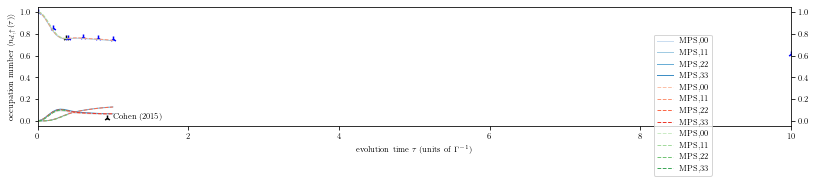

In [165]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    "font.size" : 8
})
def cl(va,lt,cmap='Blues',invert=False,margin=0.1,lowcut=0,upcut=1): 
    cmap = plt.cm.get_cmap(cmap)
    ind=list(lt).index(va) 
    if len(lt)>1:
        rt=ind/(len(lt)-1)
        rt*=1-min(1-margin,lowcut+1-upcut)
        rt+=lowcut
    else:
        rt=0
        rt+=lowcut
    rt=rt*(1-2*margin)+margin
    if invert:
        rt=1-rt    
    return cmap(rt)


interval = 1

Gamma = 1.
fig, ax = plt.subplots()
fig.set_size_inches(13.5,2.2) 

ax.tick_params(labelright=True)
ax.yaxis.set_ticks_position('both')
ax.set_xlim(left = 0)
ax.set_xlim(right =10)

dms05 = np.array(dms05)
z=6
#ax.plot(np.arange(0,1001)*delta_t*0.05 ,data_trace[::2],linewidth=1,linestyle= '-',label='MPS '+ r'$Tr(\rho)$',color=cl(z,[0,1,2,3,4,5,6]))
z=1
ax.plot(np.arange(0,21)*0.05 ,dms05[::2,0,0],linewidth=1,linestyle= '-',label='MPS,00',color=cl(z,[0,1,2,3,4,5,6]))
z=2
ax.plot(np.arange(0,21)*0.05,  dms05[::2,1,1],linewidth=1,linestyle= '-',label='MPS,11',color=cl(z,[0,1,2,3,4,5,6]))
z=3
ax.plot(np.arange(0,21)*0.05 ,dms05[::2,2,2],linewidth=1,linestyle= '-',label='MPS,22',color=cl(z,[0,1,2,3,4,5,6]))
z=4
ax.plot(np.arange(0,21)*0.05 ,dms05[::2,3,3],linewidth=1,linestyle= '-',label='MPS,33',color=cl(z,[0,1,2,3,4,5,6]))
z=5

def cl(va,lt,cmap='Reds',invert=False,margin=0.1,lowcut=0,upcut=1): 
    cmap = plt.cm.get_cmap(cmap)
    ind=list(lt).index(va) 
    if len(lt)>1:
        rt=ind/(len(lt)-1)
        rt*=1-min(1-margin,lowcut+1-upcut)
        rt+=lowcut
    else:
        rt=0
        rt+=lowcut
    rt=rt*(1-2*margin)+margin
    if invert:
        rt=1-rt    
    return cmap(rt)

dms025 = np.array(dms025)
z=6
#ax.plot(np.arange(0,1001)*delta_t*0.05 ,data_trace[::2],linewidth=1,linestyle= '-',label='MPS '+ r'$Tr(\rho)$',color=cl(z,[0,1,2,3,4,5,6]))
z=1
ax.plot(np.arange(0,41)*0.025 ,dms025[::2,0,0],linewidth=1,linestyle= '--',label='MPS,00',color=cl(z,[0,1,2,3,4,5,6]))
z=2
ax.plot(np.arange(0,41)*0.025,  dms025[::2,1,1],linewidth=1,linestyle= '--',label='MPS,11',color=cl(z,[0,1,2,3,4,5,6]))
z=3
ax.plot(np.arange(0,41)*0.025 ,dms025[::2,2,2],linewidth=1,linestyle= '--',label='MPS,22',color=cl(z,[0,1,2,3,4,5,6]))
z=4
ax.plot(np.arange(0,41)*0.025 ,dms025[::2,3,3],linewidth=1,linestyle= '--',label='MPS,33',color=cl(z,[0,1,2,3,4,5,6]))
z=5

def cl(va,lt,cmap='Greens',invert=False,margin=0.1,lowcut=0,upcut=1): 
    cmap = plt.cm.get_cmap(cmap)
    ind=list(lt).index(va) 
    if len(lt)>1:
        rt=ind/(len(lt)-1)
        rt*=1-min(1-margin,lowcut+1-upcut)
        rt+=lowcut
    else:
        rt=0
        rt+=lowcut
    rt=rt*(1-2*margin)+margin
    if invert:
        rt=1-rt    
    return cmap(rt)

dms01 = np.array(dms01)
z=6
#ax.plot(np.arange(0,1001)*delta_t*0.05 ,data_trace[::2],linewidth=1,linestyle= '-',label='MPS '+ r'$Tr(\rho)$',color=cl(z,[0,1,2,3,4,5,6]))
z=1
ax.plot(np.arange(1,41)*0.01 ,dms01[1::2,0,0],linewidth=1,linestyle= '--',label='MPS,00',color=cl(z,[0,1,2,3,4,5,6]))
z=2
ax.plot(np.arange(1,41)*0.01,  dms01[1::2,1,1],linewidth=1,linestyle= '--',label='MPS,11',color=cl(z,[0,1,2,3,4,5,6]))
z=3
ax.plot(np.arange(1,41)*0.01 ,dms01[1::2,2,2],linewidth=1,linestyle= '--',label='MPS,22',color=cl(z,[0,1,2,3,4,5,6]))
z=4
ax.plot(np.arange(1,41)*0.01 ,dms01[1::2,3,3],linewidth=1,linestyle= '--',label='MPS,33',color=cl(z,[0,1,2,3,4,5,6]))
z=5

Cohen_empty_x = [.383]
Cohen_empty_y = [.763]
plt.scatter(Cohen_empty_x,Cohen_empty_y,color='black',marker="2")#,label='Segal, Millis, Reichmann (2010)'

Cohen_empty_x = [0,0.2,0.4,0.6,0.8,1.,10]
Cohen_empty_y = [1.,0.858,0.766,0.767,0.76,.749,.611]
plt.scatter(Cohen_empty_x,Cohen_empty_y,color='blue',marker="2")#,label='Segal, Millis, Reichmann (2010)'
"""
Cohen_up_x = [0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,1.8,2.,2.2,2.4,2.5]
Cohen_up_y = [0.1033,0.111,0.116,0.123,0.129,0.1363,0.143,0.1461,0.139,0.1311,0.1261,0.1206,0.11778,0.11667,0.11667,0.11667, 0.117]
plt.scatter(Cohen_up_x,Cohen_up_y,color='black',marker="2")

Cohen_down_x = [.2,0.25,.3,.35,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,1.8,2.,2.2,2.4,2.5]
Cohen_down_y = [0.12,0.135,.14667,.1589,0.17,0.1868,0.201,.21889,.222,.21944,.218,.215,.2127,.2123,.2122,.2123,.213]
plt.scatter(Cohen_down_x,Cohen_down_y,color='black',marker="2")

Cohen_both_x = [.2,0.25,.3,.35,0.4,0.5,0.6,.8,1,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.5]
Cohen_both_y = [.137,0.1595,.1778,.1956,0.2128,0.2403,0.263,.2972,0.3105,.3161,.3194,.3189,.3183,.3189,.319,.3194,0.32]
plt.scatter(Cohen_both_x,Cohen_both_y,color='black',marker="2")
"""
plt.xlabel('evolution time '+r'$\tau$'+ ' (units of '+ r'$\Gamma^{-1}$)')
plt.ylabel('occupation number '+r'$\langle n_{d,\uparrow}(\tau)\rangle$')
#print(data_times)
ax.legend(bbox_to_anchor=(.9, 0.8))

plt.scatter(0.92,0.031,color='black',marker="2")
ax.text(1.,0.025,'Cohen (2015)')
#ax.text(.0097,0.145,'cutoff: ' + r'$\epsilon = 10^{-10}$')
#ax.text(.25,0.04,'Segal, Millis, Reichmann (2011)')
#plt.show()
plt.savefig('/Users/julianthoenniss/Documents/PhD/data/MPS_Cohen_benchmark.pdf', bbox_inches='tight',dip=300)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


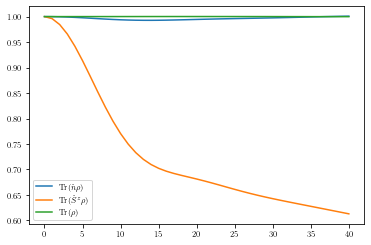

In [125]:
plt.plot([np.trace(np.diag([2,1,1,0])@d) for d in dms025[::2]],label="$\\mathrm{Tr}(\\hat{n}\\rho)$")
plt.plot([np.trace(np.diag([0,1,-1,0])@d) for d in dms025[::2]],label="$\\mathrm{Tr}(\\hat{S}^z\\rho)$")
plt.plot([np.trace(d) for d in dms025[::2]],label="$\\mathrm{Tr}(\\rho)$")
plt.legend()
plt.savefig("result.pdf")
plt.show()